<a href="https://colab.research.google.com/github/MihailMV/Fruits-and-vegetables/blob/master/NN_fruits_and_vegetables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import zipfile
import shutil
import numpy as np
import pandas as pd

from tqdm import tqdm

from PIL import Image

In [0]:
DIR = 'fruits_vegetables'
DIR_TRAIN = 'TRAIN'
DIR_VAL = 'VAL'
DIR_TEST = 'TEST'
IMG_SIZE = (224, 224)
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
BATCH_SIZE = 150

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/kaggle/" 

In [4]:
os.system("kaggle datasets download -p " + DIR + " --unzip balalexv/fruits-vegetables-photos")

0

In [0]:
#shutil.rmtree(DIR)


In [5]:
os.makedirs(os.path.join(DIR, DIR_VAL), exist_ok=True)

class_list = os.listdir(os.path.join(DIR,DIR_TRAIN))
cnt_train_list = []
cnt_val_list = []
cnt_test_list = []

for class_name in class_list:
  os.makedirs(os.path.join(DIR, DIR_VAL, class_name), exist_ok=True)
  for f in os.listdir(os.path.join(DIR,DIR_TRAIN, class_name)):
    if (np.random.randint(1, 11) == 1):
      shutil.move(os.path.join(DIR,DIR_TRAIN, class_name,f), os.path.join(DIR,DIR_VAL,class_name,f))
  cnt_train_list.append(len(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))))
  cnt_val_list.append(len(os.listdir(os.path.join(DIR,DIR_VAL, class_name))))
  cnt_test_list.append(len(os.listdir(os.path.join(DIR,DIR_TEST, class_name))))
  
df = pd.DataFrame({'CLASS':class_list, 'CNT_TRAIN':cnt_train_list, 'CNT_VAL':cnt_val_list, 'CNT_TEST':cnt_test_list})
del class_list, cnt_train_list, cnt_val_list, cnt_test_list

df.head()

,CLASS,CNT_TRAIN,CNT_VAL,CNT_TEST
0,gala,528,63,9
1,tomato_plum,500,55,9
2,golden,255,30,9
3,lemon,664,89,9
4,pepper_red,110,18,9


In [0]:
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import torchvision
import torch
import matplotlib.pyplot as plt

In [0]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(0.3,0.3,0.3),
    transforms.RandomRotation(degrees=90),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TRAIN), train_transforms)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_VAL), val_transforms)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


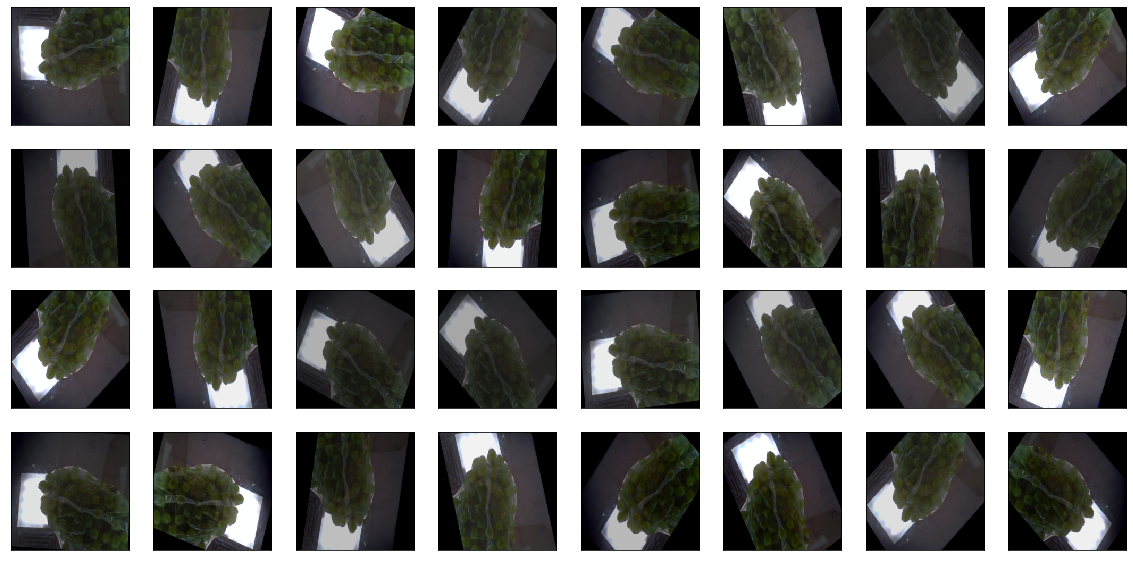

In [127]:
fig=plt.figure(figsize=(20, 10))
columns = 8
rows = 4
class_name = 'sultana'
num_photo = 42
img = Image.open(os.path.join(DIR,DIR_TRAIN,class_name,os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))[num_photo]))

for i in range(columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    if (i == 0):
      plt.imshow((val_transforms(img).permute(1, 2, 0).numpy() * STD + MEAN).clip(0, 1))
    else:
      plt.imshow((train_transforms(img).permute(1, 2, 0).numpy() * STD + MEAN).clip(0, 1))
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

In [0]:
def train_model(model, fun_loss, optimizer, scheduler, num_epochs, hist = None):
  if (hist == None):
    hist = {'Epochs': [], 'Train loss': [],'Train acc': [],'Val loss': [],'Val acc': []}
    start_epoch = 1
  else:
    start_epoch = hist['Epochs'][-1]+1
  type_trains = ['Train','Val']
  for epoch in range(start_epoch, start_epoch+num_epochs):
    # Train
    for id_type_train in range(2):
      #print(type_trains[id_type_train], flush=True)
      loss = 0.
      acc = 0.
      if (id_type_train == 0):
        model.train()
        dataloader = train_dataloader
      else:
        model.eval()
        dataloader = val_dataloader
      #for inputs, labels in tqdm(dataloader):
      for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(id_type_train == 0):
          preds = model(inputs)
          loss_batch = fun_loss(preds, labels)
          preds_class = preds.argmax(dim=1)
          if (id_type_train == 0):
            loss_batch.backward()
            optimizer.step()
          loss += loss_batch.item()
          acc += (preds_class == labels.data).float().mean().item()
      
      loss /= len(dataloader)
      acc /= len(dataloader)
      if (id_type_train == 0):
        scheduler.step(loss)
        hist['Epochs'].append(epoch)
        hist['Train loss'].append(loss)
        hist['Train acc'].append(acc)
      else:
        hist['Val loss'].append(loss)
        hist['Val acc'].append(acc)
    
    print(f"Epoch {epoch}/{start_epoch+num_epochs-1}: Train: Loss: {hist['Train loss'][-1]:.4f}, Acc: {hist['Train acc'][-1]:.4f}   Val: Loss: {hist['Val loss'][-1]:.4f}, Acc: {hist['Val acc'][-1]:.4f}")

  return model, hist

In [0]:
cl_cnt = {}
for class_name in os.listdir(os.path.join(DIR,DIR_TRAIN)):
  cl_cnt[class_name] = 0
  for i, f in enumerate(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))):
    cl_cnt[class_name] += 1

In [0]:
#pip install efficientnet_pytorch
#from efficientnet_pytorch import EfficientNet
#model = EfficientNet.from_pretrained("efficientnet-b4") #, num_classes = len(train_dataset.classes))
#model._fc = torch.nn.Linear(model._fc.in_features, len(train_dataset.classes))


In [0]:
model = models.resnet50(pretrained=True)

#for param in model.parameters():
#    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

cl_weight = max([cnt for cnt in cl_cnt.values()]) / torch.tensor([cl_cnt[cl] for cl in train_dataset.classes], dtype=float, device=device)

loss = torch.nn.CrossEntropyLoss(weight=cl_weight.float())
#loss = torch.nn.NLLLoss(weight=cl_weight.float())

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,  amsgrad=True)
#weight_decay = 1e-5,

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.3, patience=3, threshold= 0.01, verbose=True)

In [207]:
model, hist = train_model(model, loss, optimizer, scheduler, num_epochs=5)

Epoch 1/5: Train: Loss: 0.9995, Acc: 0.7757   Val: Loss: 0.1680, Acc: 0.9333
Epoch 2/5: Train: Loss: 0.1077, Acc: 0.9644   Val: Loss: 0.0750, Acc: 0.9765
Epoch 3/5: Train: Loss: 0.0524, Acc: 0.9821   Val: Loss: 0.0296, Acc: 0.9916
Epoch 4/5: Train: Loss: 0.0377, Acc: 0.9892   Val: Loss: 0.0296, Acc: 0.9916
Epoch 5/5: Train: Loss: 0.0324, Acc: 0.9905   Val: Loss: 0.0431, Acc: 0.9797


In [210]:
model, hist = train_model(model, loss, optimizer, scheduler, num_epochs=3, hist=hist)

Epoch 6/8: Train: Loss: 0.0302, Acc: 0.9910   Val: Loss: 0.0203, Acc: 0.9933
Epoch 7/8: Train: Loss: 0.0191, Acc: 0.9949   Val: Loss: 0.0157, Acc: 0.9967
Epoch 8/8: Train: Loss: 0.0181, Acc: 0.9949   Val: Loss: 0.0199, Acc: 0.9933


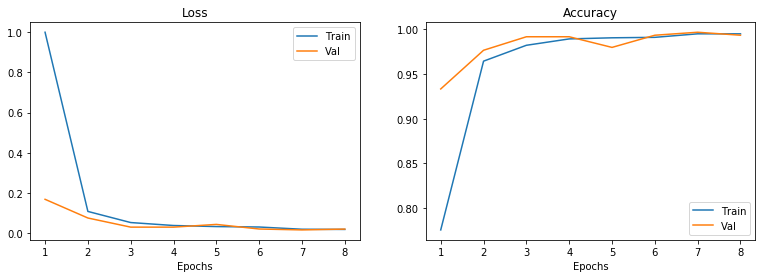

In [211]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
fig.set(facecolor = 'white')
axes[0].plot(hist['Epochs'], hist['Train loss'], label='Train')
axes[0].plot(hist['Epochs'], hist['Val loss'], label='Val')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend()
axes[1].plot(hist['Epochs'], hist['Train acc'], label='Train')
axes[1].plot(hist['Epochs'], hist['Val acc'], label='Val')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend()
plt.show()

In [212]:
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TEST), val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=50, shuffle=False, num_workers=8)


model.eval()

test_predictions = []
test_img_paths = []

running_loss = 0.
running_acc = 0.

for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
        preds_class = preds.argmax(dim=1)
        running_acc += (preds_class == labels.data).float().sum().cpu()

#del inputs, labels
print(running_acc.item() / len(test_dataset), len(test_dataset) - running_acc.item())

0.9629629629629629 5.0


In [0]:
for i in range(inputs.size()[0]):
  if (preds_class[i] != labels.data[i]):
    show_input(inputs[i].cpu(), train_dataset.classes[preds_class[i]])


In [200]:
!nvidia-smi

Mon Mar  2 21:54:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    29W /  70W |  14907MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
def Occlusion(model, img, class_id, batch_size = 32, size_square = 20, size_step = 5):
  img = img.view([1] + list(img.size()))
  len_row = img.size()[2] // size_step + 1
  len_col = img.size()[3] // size_step + 1
  confidence_predict = []
  i = 0
  j = 0

  for num_batcn in range(1, (len_row * len_col) // batch_size + 2):
    cnt_img = batch_size - max(0,num_batcn * batch_size - (len_row * len_col))
    imgs = torch.cat([img for i in range(cnt_img)])  
    for num_img in range(cnt_img):
      imgs[num_img, :, i*size_step:i*size_step+size_square, j*size_step:j*size_step+size_square] *= 0
      j += 1
      if (j == len_col):
        i += 1
        j = 0 
    confidence_predict = np.concatenate([confidence_predict ,list(torch.nn.functional.softmax(model(imgs).data ,dim=1)[:,class_id].cpu().numpy())])


  new_img = torch.zeros(img.size()[2:])
  new_img_cnt = torch.zeros(img.size()[2:])

  #print(confidence_predict.min(), confidence_predict.max())
  for i in range(len_row):
    for j in range(len_col):
      new_img[i*size_step:i*size_step+size_square, j*size_step:j*size_step+size_square] += confidence_predict[i* len_row + j]
      new_img_cnt[i*size_step:i*size_step+size_square, j*size_step:j*size_step+size_square] += 1

  new_img /= new_img_cnt
  #show_input(img[0].cpu())
  #new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min())
  #show_input(torch.cat([1-new_img.view([1] + list(img.size()[2:])), torch.zeros([1] + list(img.size()[2:])), new_img.view([1] + list(img.size()[2:]))]), normalize=False)
  #img_Saliency
  img2 = img.clone()
  img2.requires_grad = True

  img = img[0].cpu().permute(1, 2, 0).numpy()
  img = STD * img + MEAN
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
  fig.set(facecolor = 'white')
  axes[0].imshow(img.clip(0, 1))
  axes[0].set(title = 'Original', xticks=[], yticks=[])


  im = axes[2].imshow(new_img, cmap='RdBu')
  axes[2].set(title = 'Occlusion', xticks=[], yticks=[])
  fig.colorbar(im, ax=axes.ravel().tolist())
  
  
  optimizer = torch.optim.Adam([img2], lr=1.0e-1, weight_decay = 0.05, amsgrad=True)
  optimizer.zero_grad()
  loss_value = loss(model(img2), torch.tensor([class_id]).to(device))
  loss_value.backward()
  optimizer.step()
  new_img = -img2.grad.abs().sum(dim=(0,1)).cpu()
  new_img = new_img - new_img.median() / 2
  new_img = new_img.data.relu()
  im2 = axes[1].imshow(new_img)
  axes[1].set(title = 'Saliency', xticks=[], yticks=[])
 
  plt.show()



    #plt.imshow(image.clip(0, 1))
    #plt.title(title)
    
    #plt.pause(0.001)


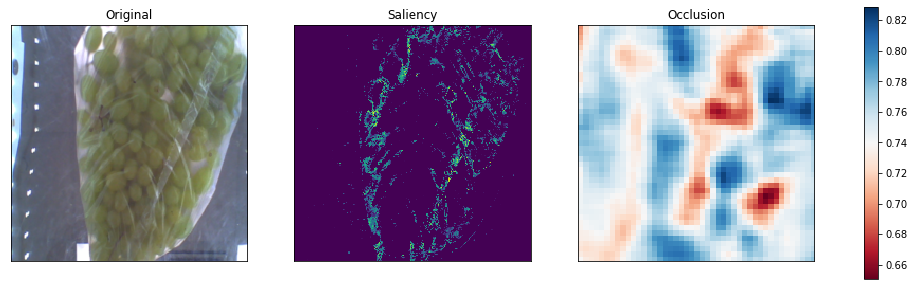

In [0]:
num_photo = 99
img = inputs[num_photo]
class_id = labels[num_photo].item()
Occlusion(model, img, class_id, batch_size = 150, size_square = 20, size_step = 5)
